# Intro
Welcome to the year 2912. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, my task is to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Objective
- Prepare model(-s) to predict which passengers were transported by the anomaly and test model accuracy via the Kaggle platform.
- Make model(-s) at least 79% accurate on test data.

# Data preprocessing

## Packages import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, pointbiserialr
import math
import warnings
import logging
import sys
import os

from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.calibration import cross_val_predict
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier

import inspect
import optuna
import lightgbm as lgb
import shap
import xgboost as xgb
import catboost as cb

from contextlib import redirect_stdout
from IPython.display import Image, display

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 2
from functions import *
%reload_ext autoreload

C:\Users\rokas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data import

In [2]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
print('Train data shape:', data_train.shape)
print('Test data shape:', data_test.shape)
data_train.head()

Train data shape: (8693, 14)
Test data shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Column descriptions:**
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Data split**  
Data is split at about 2:1 ratio with training data making up approximately 67% of total observations.
Since the data is already split with appropriate ratio, it will not be split anymore. Initially, model accuracy will be tested using cross-validation until satisfying results are met (at least 79% accuracy). Afterwards, ultimate model accuracy will be evaluated on Kaggle platform by submitting test data predictions.

# Exploratory Data Analysis

## Statistical summaries

In [3]:
data_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- **Age**: The average age is about 29 years, with most people being between 19 and 38 years old. The youngest is 0, and the oldest is 79.
- **Spending**: There’s a wide range of spending in categories like RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck. For example, while the average RoomService spend is around 225, some individuals spent as much as 14,327. Similarly, the FoodCourt spend averages 458, but goes up to nearly 30,000 in some cases. This suggests a significant variation in how passengers spend money.
- **Missing data**: There are some missing values in almost all the columns.

## Missing values

In [5]:
num_rows_with_missing_values = data_train.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {num_rows_with_missing_values}")
print('Total:', data_train.shape[0])

Number of rows with at least one missing value: 2087
Total: 8693


Almost a quarter of total training observations are missing at least one value. It wouldn't be wise to drop all of them, so more analysis will be done later on.

In [6]:
num_rows_with_missing_values = data_test.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {num_rows_with_missing_values}")
print('Total:', data_test.shape[0])

Number of rows with at least one missing value: 996
Total: 4277


Nearly identical situation in the test set somewhat proving significant similarities between the two datasets.

## Correlations

Now will draw two correlation heatmaps (Point-Biserial for numerical and Cramer's V for categorical) to better understand how features interact with the target feature `Transported`.
- Why Point-Biserial for numerical features? Because the target feature is binary.
- Why Cramer's V for categorical features? Because the target feature is binary as well as it's advanced technique allows to measure complex categorical data.

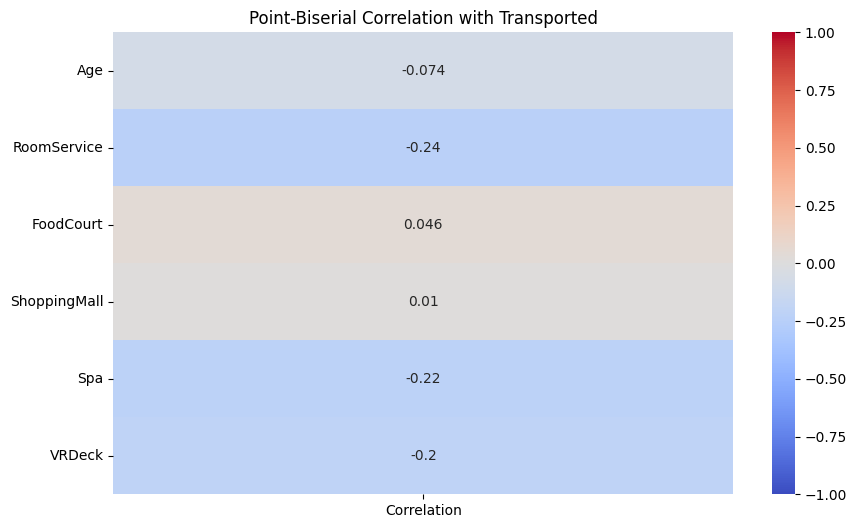

In [7]:
temp_data_train = data_train.copy()
temp_data_train = temp_data_train.drop(columns=['PassengerId', 'Name'])

temp_data_train.fillna({
    col: temp_data_train[col].mean() if temp_data_train[col].dtype in [np.float64, np.int64] else temp_data_train[col].mode()[0]
    for col in temp_data_train.columns
}, inplace=True)

numerical_features = temp_data_train.select_dtypes(include=[np.number])
correlations = {}
for col in numerical_features.columns:
    if col != 'Transported':
        correlation, _ = pointbiserialr(temp_data_train['Transported'], temp_data_train[col])
        correlations[col] = correlation

correlations_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
plt.figure(figsize=(10, 6))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Point-Biserial Correlation with Transported')
plt.show()

No very significant correlations found between the numerical features and the target variable.

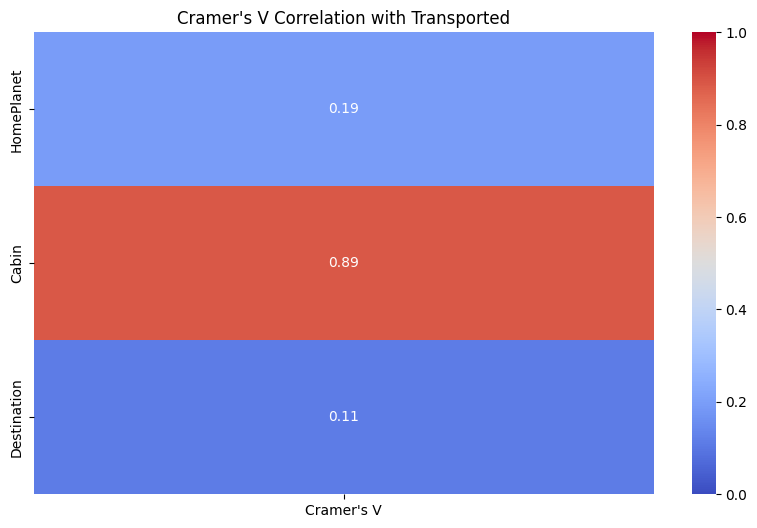

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

categorical_features = temp_data_train.select_dtypes(include=['object', 'category'])
cramers_v_results = {}
for col in categorical_features.columns:
    if col != 'Transported':
        cramers_v_results[col] = cramers_v(temp_data_train[col], temp_data_train['Transported'])

cramers_v_df = pd.DataFrame.from_dict(cramers_v_results, orient='index', columns=['Cramer\'s V'])

plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cramer\'s V Correlation with Transported')
plt.show()

Categorical features show more promising results compared to numerical features but it's still difficult to estimate the importance of each feature.

## Outliers

As seen in descriptive statistics part, this data definitely has some outliers. Will use IQR method to detect and remove them with custom upper and lower bounds.

### Age

Statistics for Age:
count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64
Label distribution for outliers in Age:
False    7
True     3
Name: Transported, dtype: int64
Number of affected observations in Age: 10
Top 10 most extreme outliers in Age:
       Original  Potential Replacement  Transported
338       79.0                   75.5        False
615       79.0                   75.5        False
4682      79.0                   75.5        False
1429      78.0                   75.5        False
2361      78.0                   75.5        False
6146      78.0                   75.5         True
2930      77.0                   75.5         True
3526      77.0                   75.5        False
1390      76.0                   75.5        False
8288      76.0                   75.5         True


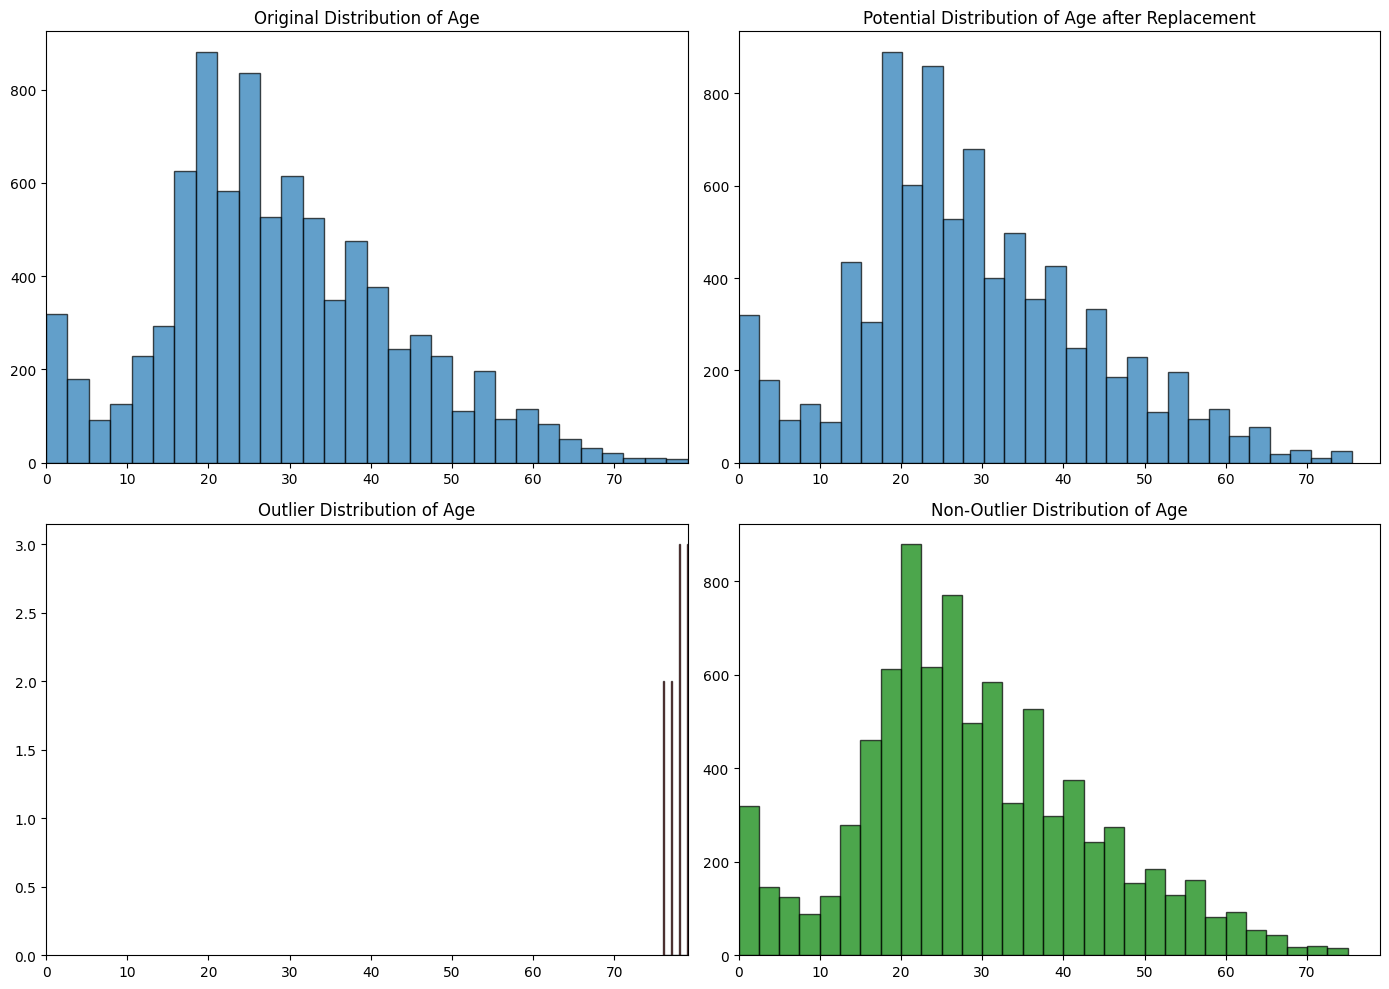

In [9]:
investigate_outliers(data_train, 'Age', 0.2, 0.8)

In [10]:
data_train = replace_outliers(data_train, 'Age', 0.2, 0.8)

Outlier replacement in 'Age' was successful.
Number of observations affected: 10
Percentage of total observations affected: 0.12%
Average original value: 28.82793046746535
Average outlier value: 77.7
Average value after replacement: 28.825346488137185


### RoomService

Statistics for RoomService:
count     8512.000000
mean       224.687617
std        666.717663
min          0.000000
25%          0.000000
50%          0.000000
75%         47.000000
max      14327.000000
Name: RoomService, dtype: float64
Label distribution for outliers in RoomService:
False    76
True      5
Name: Transported, dtype: int64
Number of affected observations in RoomService: 81
Top 10 most extreme outliers in RoomService:
       Original  Potential Replacement  Transported
4416   14327.0               3185.625        False
5105    9920.0               3185.625        False
8626    8586.0               3185.625        False
7933    8243.0               3185.625        False
7118    8209.0               3185.625        False
1177    8168.0               3185.625        False
4762    8151.0               3185.625        False
5725    8142.0               3185.625        False
928     8030.0               3185.625        False
75      7406.0               3185.625        False


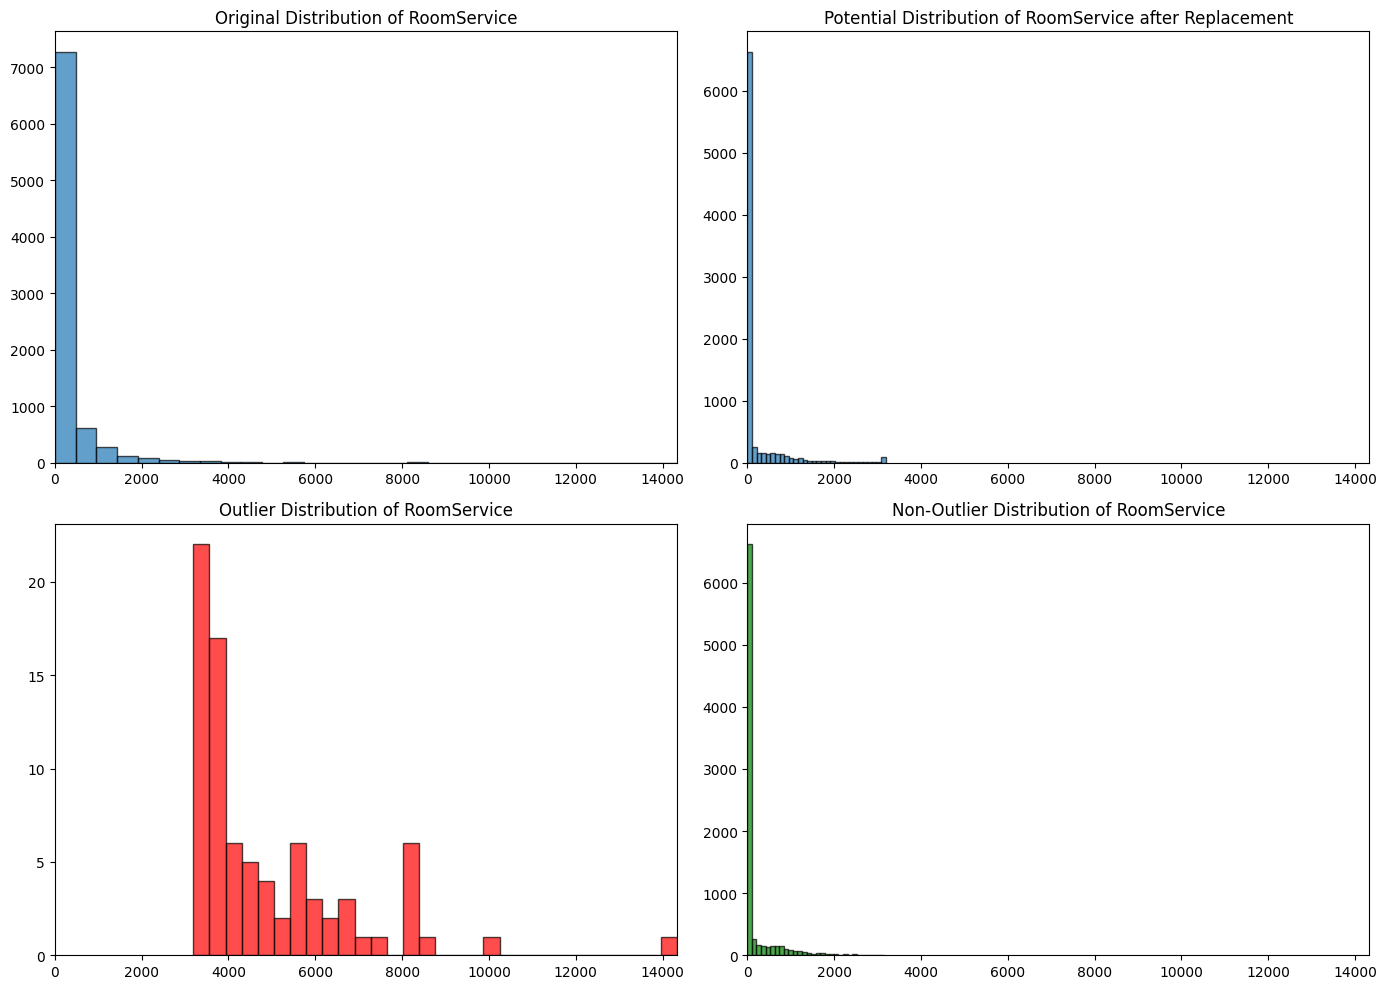

In [11]:
investigate_outliers(data_train, 'RoomService', 0.05, 0.95)

In [12]:
data_train = replace_outliers(data_train, 'RoomService', 0.05, 0.95)

Outlier replacement in 'RoomService' was successful.
Number of observations affected: 81
Percentage of total observations affected: 0.95%
Average original value: 224.687617481203
Average outlier value: 4894.679012345679
Average value after replacement: 208.42429804981202


### FoodCourt

Statistics for FoodCourt:
count     8510.000000
mean       458.077203
std       1611.489240
min          0.000000
25%          0.000000
50%          0.000000
75%         76.000000
max      29813.000000
Name: FoodCourt, dtype: float64
Label distribution for outliers in FoodCourt:
True     82
False    36
Name: Transported, dtype: int64
Number of affected observations in FoodCourt: 118
Top 10 most extreme outliers in FoodCourt:
       Original  Potential Replacement  Transported
2067   29813.0                6871.25         True
1213   27723.0                6871.25         True
3198   27071.0                6871.25         True
3538   26830.0                6871.25         True
1842   21066.0                6871.25         True
3180   18481.0                6871.25         True
6508   17958.0                6871.25         True
7520   17901.0                6871.25         True
4083   17687.0                6871.25         True
3428   17432.0                6871.25         True


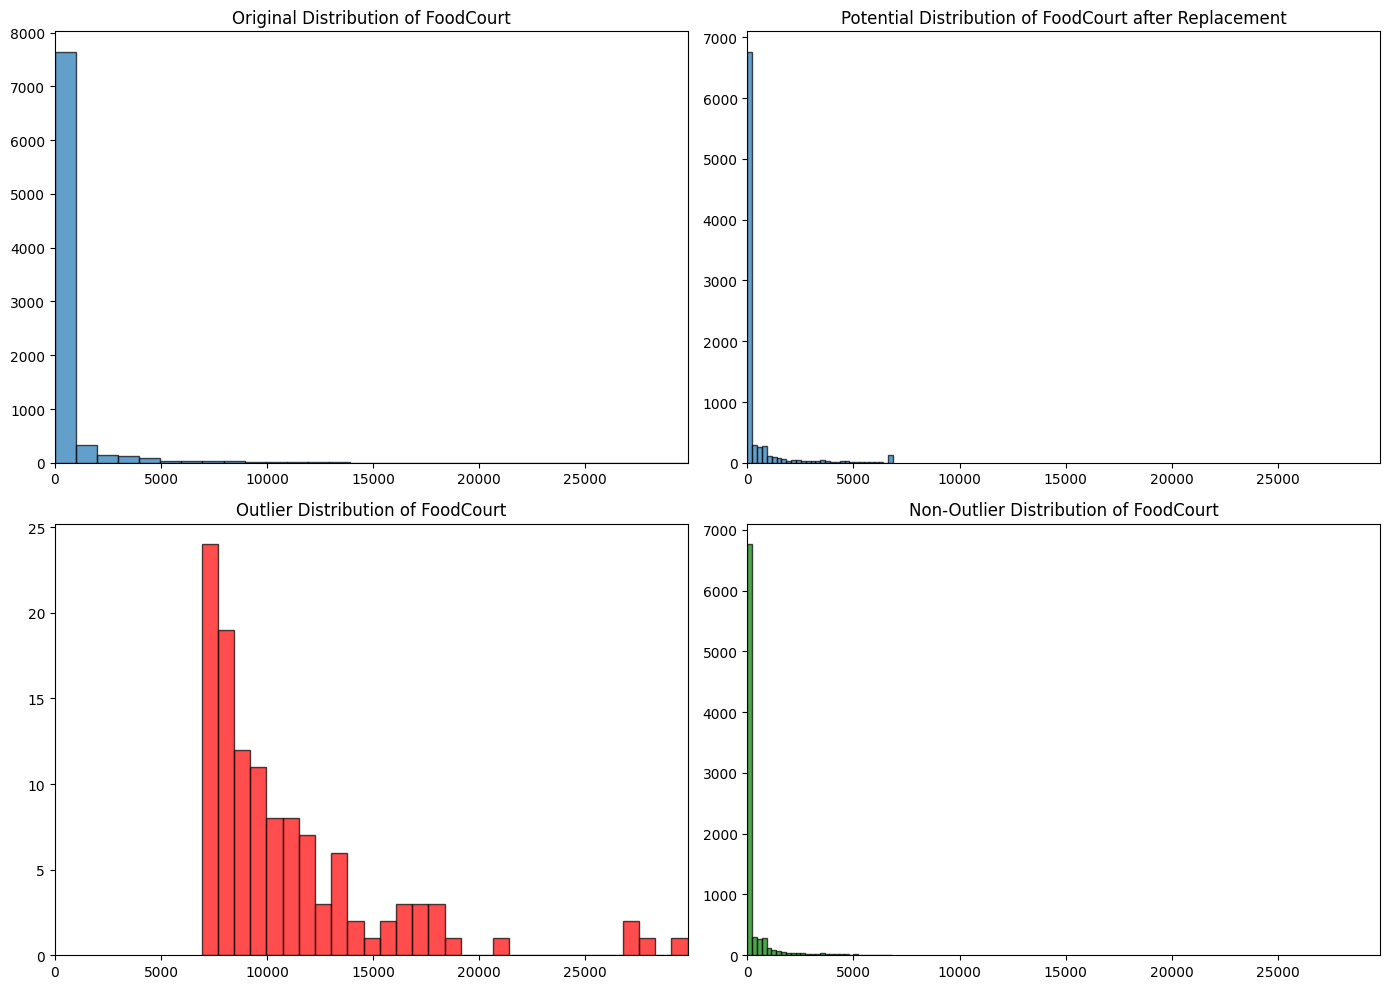

In [13]:
investigate_outliers(data_train, 'FoodCourt', 0.05, 0.95)

In [14]:
data_train = replace_outliers(data_train, 'FoodCourt', 0.05, 0.95)

Outlier replacement in 'FoodCourt' was successful.
Number of observations affected: 118
Percentage of total observations affected: 1.39%
Average original value: 458.07720329024676
Average outlier value: 10956.127118644068
Average value after replacement: 401.43613396004616


### ShoppingMall

Statistics for ShoppingMall:
count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64
Label distribution for outliers in ShoppingMall:
True     60
False    27
Name: Transported, dtype: int64
Number of affected observations in ShoppingMall: 87
Top 10 most extreme outliers in ShoppingMall:
       Original  Potential Replacement  Transported
8415   23492.0                 2319.5         True
6223   12253.0                 2319.5         True
7425   10705.0                 2319.5        False
4724   10424.0                 2319.5        False
5673    9058.0                 2319.5         True
6453    7810.0                 2319.5         True
385     7185.0                 2319.5         True
8315    7148.0                 2319.5         True
637     7104.0                 2319.5         True
5137    6805.0                 2319.5         

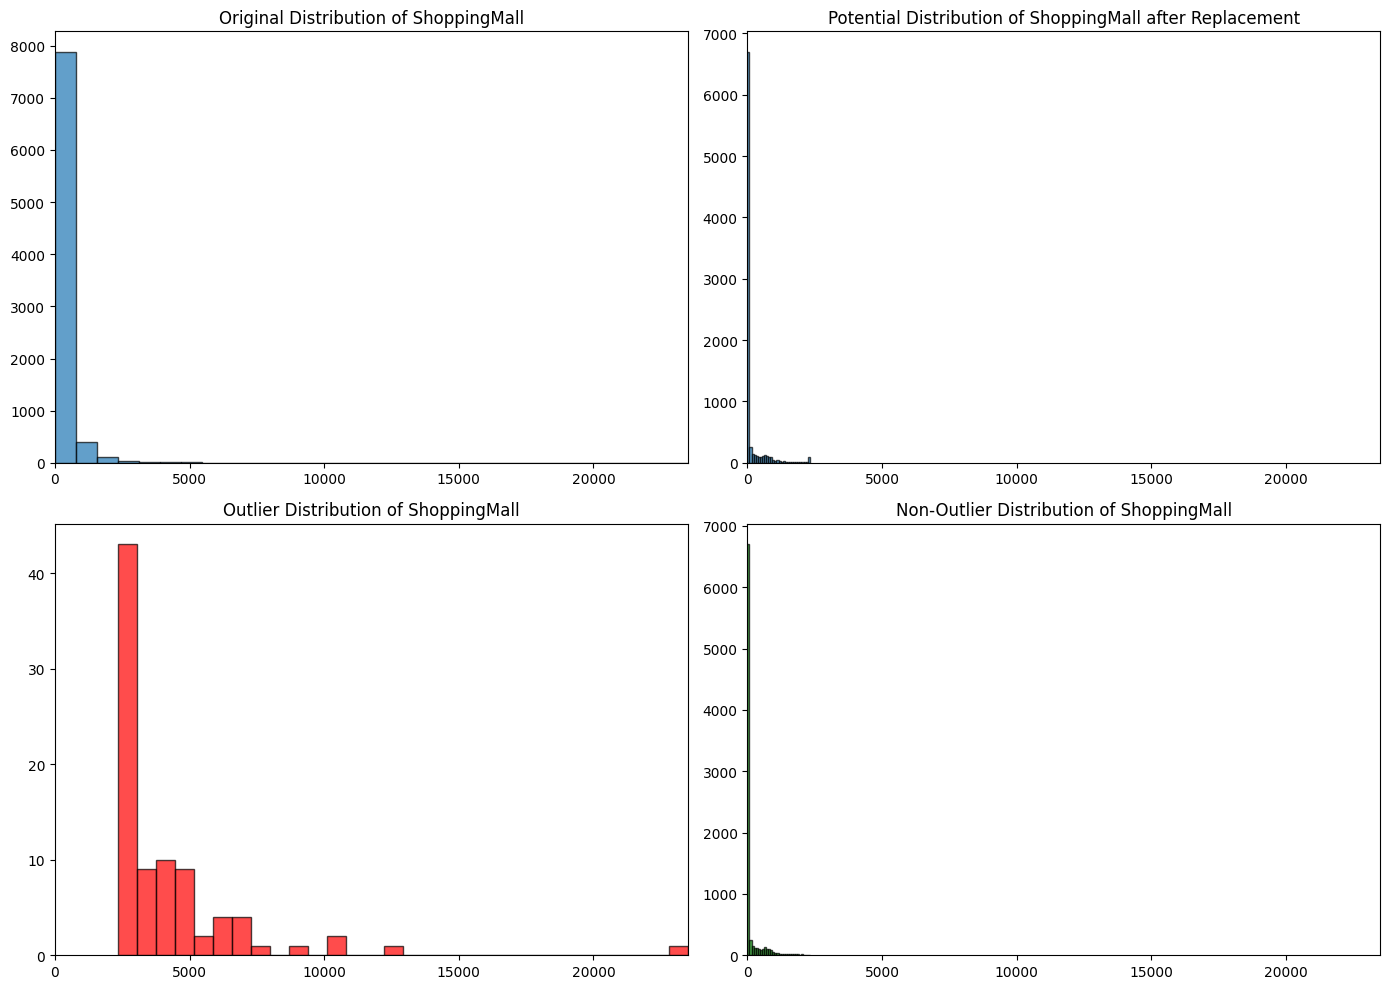

In [15]:
investigate_outliers(data_train, 'ShoppingMall', 0.05, 0.95)

In [16]:
data_train = replace_outliers(data_train, 'ShoppingMall', 0.05, 0.95)

Outlier replacement in 'ShoppingMall' was successful.
Number of observations affected: 87
Percentage of total observations affected: 1.03%
Average original value: 173.72916912197996
Average outlier value: 4197.896551724138
Average value after replacement: 154.46923983500295


### Spa

Statistics for Spa:
count     8510.000000
mean       311.138778
std       1136.705535
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64
Label distribution for outliers in Spa:
False    154
True       1
Name: Transported, dtype: int64
Number of affected observations in Spa: 155
Top 10 most extreme outliers in Spa:
       Original  Potential Replacement  Transported
5722   22408.0                4017.75        False
7995   18572.0                4017.75        False
1390   16594.0                4017.75        False
1095   16139.0                4017.75        False
6921   15586.0                4017.75        False
1598   15331.0                4017.75        False
4278   15238.0                4017.75        False
154    14970.0                4017.75        False
8459   13995.0                4017.75        False
7065   13902.0                4017.75        False


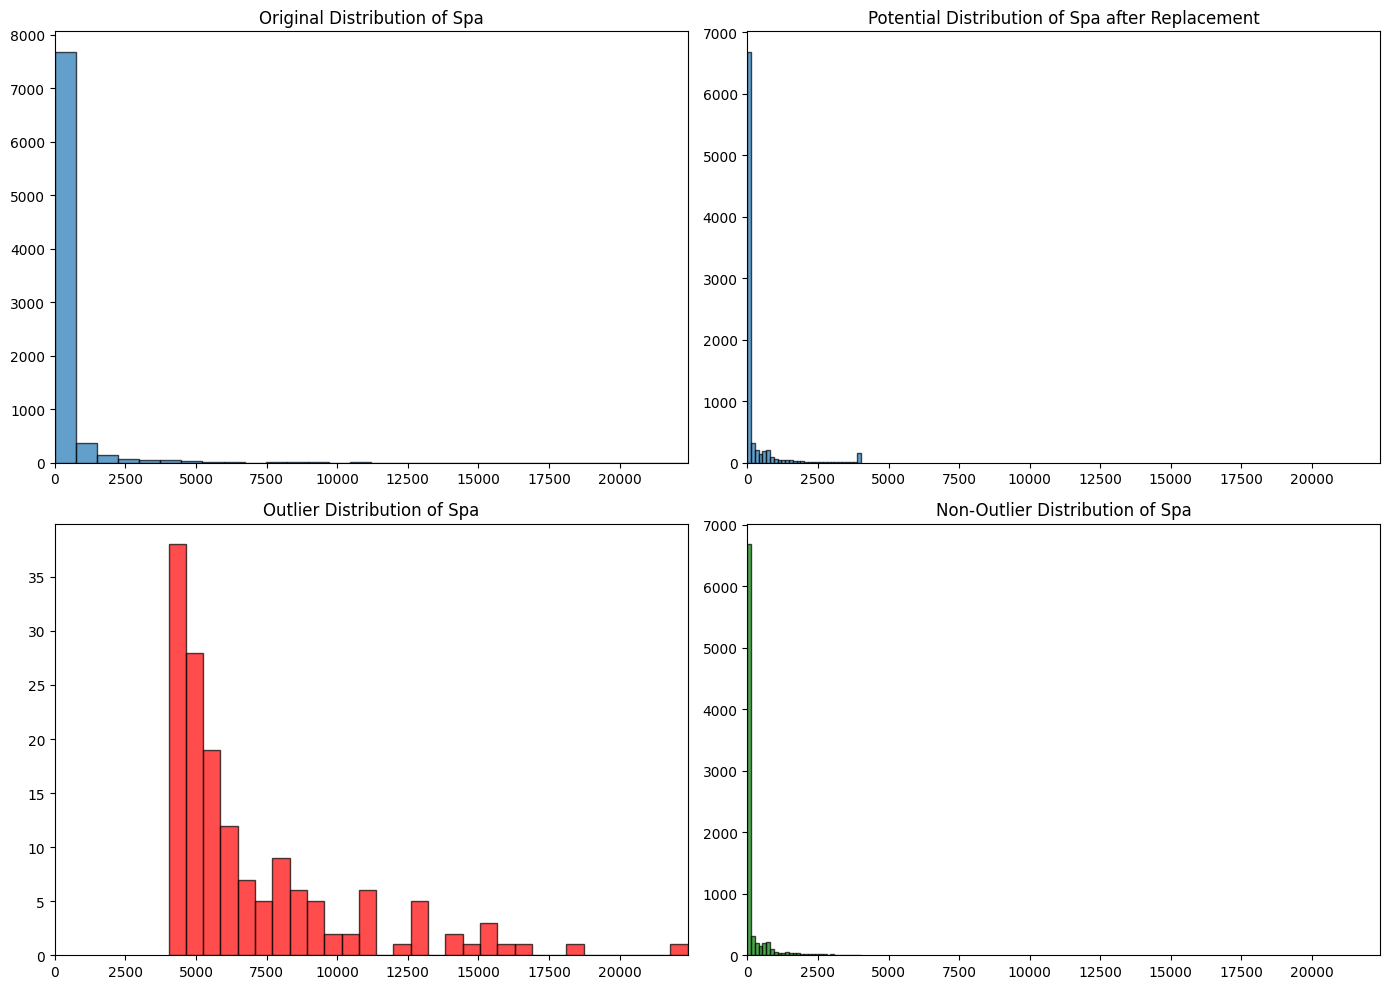

In [17]:
investigate_outliers(data_train, 'Spa', 0.05, 0.95)

In [18]:
data_train = replace_outliers(data_train, 'Spa', 0.05, 0.95)

Outlier replacement in 'Spa' was successful.
Number of observations affected: 155
Percentage of total observations affected: 1.82%
Average original value: 311.1387779083431
Average outlier value: 6966.38064516129
Average value after replacement: 257.43281433607507


### VRDeck

Statistics for VRDeck:
count     8505.000000
mean       304.854791
std       1145.717189
min          0.000000
25%          0.000000
50%          0.000000
75%         46.000000
max      24133.000000
Name: VRDeck, dtype: float64
Label distribution for outliers in VRDeck:
False    154
True       4
Name: Transported, dtype: int64
Number of affected observations in VRDeck: 158
Top 10 most extreme outliers in VRDeck:
       Original  Potential Replacement  Transported
5619   24133.0                 3835.5        False
4311   20336.0                 3835.5        False
725    17306.0                 3835.5        False
6547   17074.0                 3835.5        False
3366   16337.0                 3835.5        False
3916   14485.0                 3835.5        False
4551   12708.0                 3835.5        False
8171   12685.0                 3835.5        False
4319   12682.0                 3835.5        False
7082   12424.0                 3835.5        False


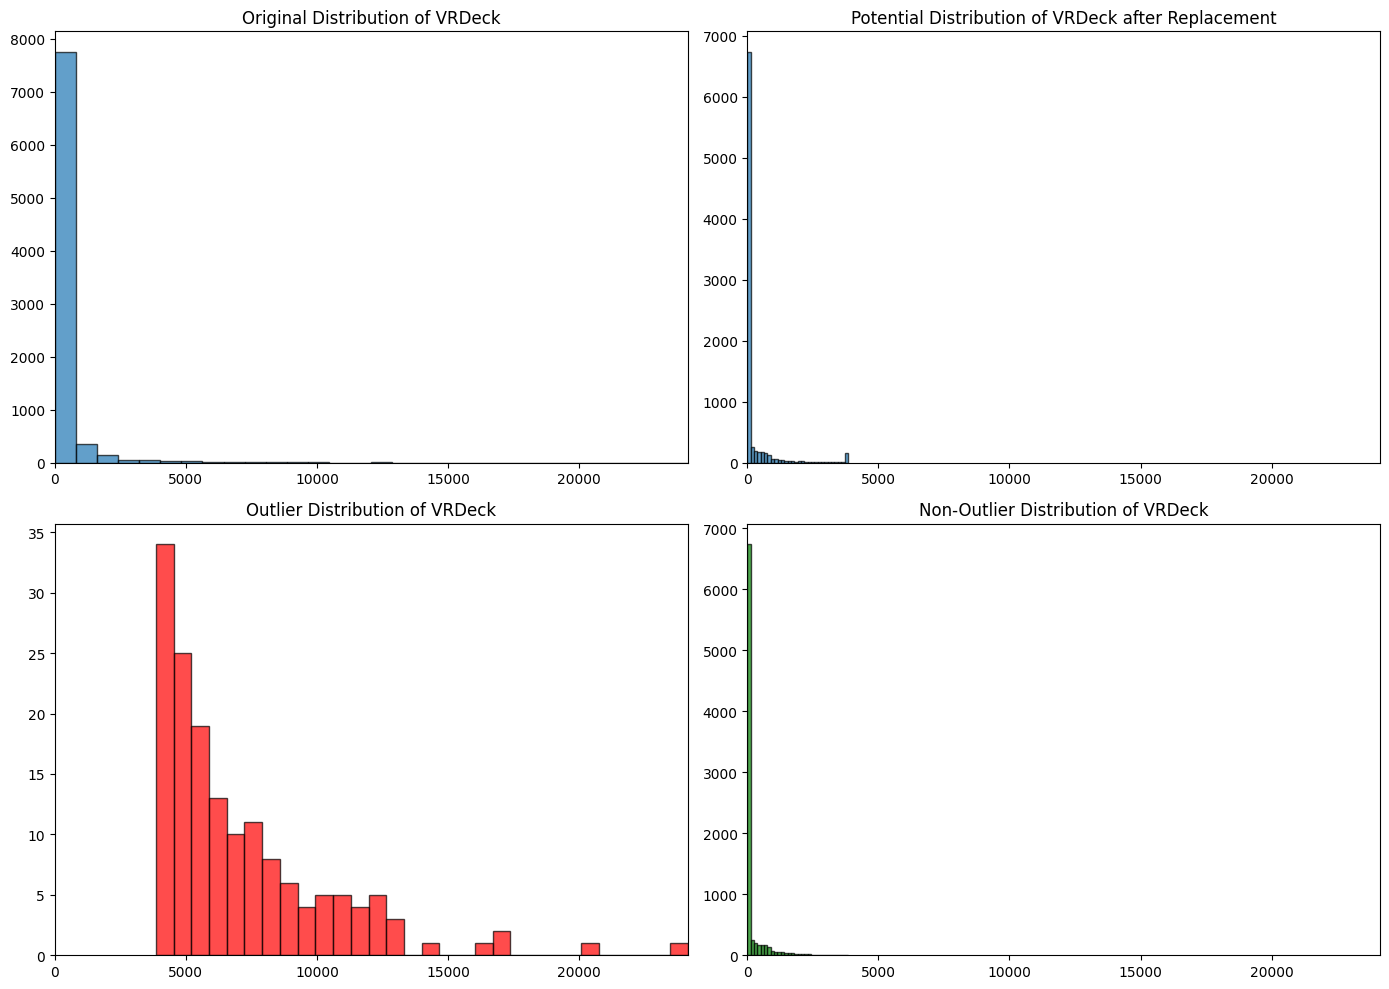

In [19]:
investigate_outliers(data_train, 'VRDeck', 0.05, 0.95)

In [20]:
data_train = replace_outliers(data_train, 'VRDeck', 0.05, 0.95)

Outlier replacement in 'VRDeck' was successful.
Number of observations affected: 158
Percentage of total observations affected: 1.86%
Average original value: 304.8547912992357
Average outlier value: 7092.512658227848
Average value after replacement: 244.34826572604268


Due to custom upper and lower bounds, approximately same amount of outliers were identified and replaced in each column.

## Binary features
Some of the features (including target feature) are binary with True/False values. These will be converted to 1/0.

In [21]:
data_train['CryoSleep'] = data_train['CryoSleep'].replace({True: 1, False: 0}).astype(float)
data_train['VIP'] = data_train['VIP'].replace({True: 1, False: 0}).astype(float)
data_train['Transported'] = data_train['Transported'].replace({True: 1, False: 0}).astype(float)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   float64
dtypes: float64(9), object(5)
memory usage: 950.9+ KB


## Hot-one encoding
`HomePlanet` and `Destination` have more than two unique values. That type of data is not usable in ML so will perform hot-one encoding.

In [22]:
homeplanet_dummies = pd.get_dummies(data_train['HomePlanet'], prefix='HomePlanet')
homeplanet_dummies[data_train['HomePlanet'].isna()] = float('nan')
destination_dummies = pd.get_dummies(data_train['Destination'], prefix='Destination')
destination_dummies[data_train['Destination'].isna()] = float('nan')
data_train = pd.concat([data_train, homeplanet_dummies, destination_dummies], axis=1)
data_train.drop(['HomePlanet', 'Destination'], axis=1, inplace=True)
print(data_train.columns)
data_train.head()

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'],
      dtype='object')


,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0.0,B/0/P,39.0,0.0,0.0,0.0,0.0,0.00,0.0,Maham Ofracculy,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0002_01,0.0,F/0/S,24.0,0.0,109.0,9.0,25.0,549.00,44.0,Juanna Vines,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0003_01,0.0,A/0/S,58.0,1.0,43.0,3576.0,0.0,4017.75,49.0,Altark Susent,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0003_02,0.0,A/0/S,33.0,0.0,0.0,1283.0,371.0,3329.00,193.0,Solam Susent,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0004_01,0.0,F/1/S,16.0,0.0,303.0,70.0,151.0,565.00,2.0,Willy Santantines,1.0,1.0,0.0,0.0,0.0,0.0,1.0


`Cabin` in also categorical with more than 2 unique values. However, it's more complicated than previous categorical features due to it having much more information in it.
It has information about deck, room nuber and the side (port or starboard). These values are split with "/" delimiter. So we'll use that same delimiter to extract information from the feature and once again use hot-one encoding for some of them.

In [23]:
data_train[['deck', 'room_number', 'side']] = data_train['Cabin'].str.split('/', expand=True)
data_train['deck'] = data_train['deck'].where(data_train['Cabin'].notna(), None)
data_train['room_number'] = data_train['room_number'].where(data_train['Cabin'].notna(), None)
data_train['side'] = data_train['side'].where(data_train['Cabin'].notna(), None)
data_train['port'] = data_train['side'].apply(lambda x: 1.0 if x == 'P' else (0.0 if x == 'S' else float('nan')))
data_train['starboard'] = data_train['side'].apply(lambda x: 1.0 if x == 'S' else (0.0 if x == 'P' else float('nan')))
deck_dummies = pd.get_dummies(data_train['deck'], prefix='deck').astype(float)
deck_dummies[data_train['deck'].isna()] = float('nan')
data_train = pd.concat([data_train, deck_dummies], axis=1)
data_train.drop(['Cabin', 'deck', 'side'], axis=1, inplace=True)
data_train['room_number'] = pd.to_numeric(data_train['room_number'], errors='coerce')

data_train.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,port,starboard,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0001_01,0.0,39.0,0.0,0.0,0.0,0.0,0.00,0.0,Maham Ofracculy,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,0.0,24.0,0.0,109.0,9.0,25.0,549.00,44.0,Juanna Vines,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0003_01,0.0,58.0,1.0,43.0,3576.0,0.0,4017.75,49.0,Altark Susent,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0003_02,0.0,33.0,0.0,0.0,1283.0,371.0,3329.00,193.0,Solam Susent,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0004_01,0.0,16.0,0.0,303.0,70.0,151.0,565.00,2.0,Willy Santantines,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Data reduction
Feels unlikely and overcomplicated that `name` had any meaning in whether the passenger was transported or not; hence, will drop that column.

In [24]:
data_train.drop(columns=['Name'], inplace=True)

## Missing values (once again)

### Unique key

In [25]:
print("Number of duplicates in Passenger ID:", data_train['PassengerId'].duplicated().sum())
print("Number of missing values in Passenger ID:", data_train['PassengerId'].isnull().sum())

Number of duplicates in Passenger ID: 0
Number of missing values in Passenger ID: 0


There are no duplicates or missing values meaning that the Passenger ID is unique for each passenger and all passangers had their id's assigned correctly. Since ID is unique and has no real meaning for the model, we can drop it.

In [26]:
data_train.drop('PassengerId', axis=1, inplace=True)

### Target feature

In [27]:
print("Number of missing values in Transported:", data_train['Transported'].isnull().sum())
print("Unique values in Transported:", data_train['Transported'].unique())

Number of missing values in Transported: 0
Unique values in Transported: [0. 1.]


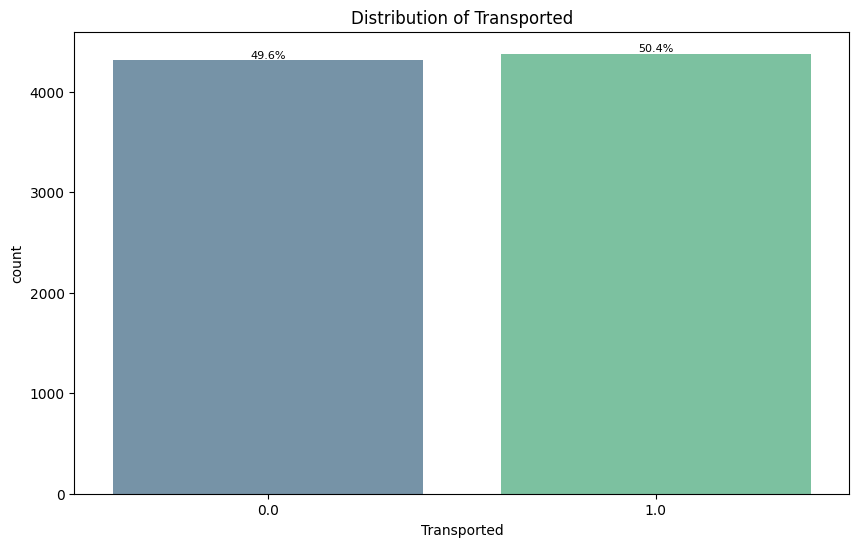

In [28]:
draw_bar_plot(data_train, 'Transported', 'Distribution of Transported')

No missing values found in `Transported` and True/False ratio is close perfect 50/50 split which is great considering this is our target feature.

### Remaining features

In [29]:
for column in data_train.columns:
 print_null_statistics(data_train, column)

Feature: CryoSleep
Missing values: 217 (2.50%)
Total: 8693
Feature: Age
Missing values: 179 (2.06%)
Total: 8693
Feature: VIP
Missing values: 203 (2.34%)
Total: 8693
Feature: RoomService
Missing values: 181 (2.08%)
Total: 8693
Feature: FoodCourt
Missing values: 183 (2.11%)
Total: 8693
Feature: ShoppingMall
Missing values: 208 (2.39%)
Total: 8693
Feature: Spa
Missing values: 183 (2.11%)
Total: 8693
Feature: VRDeck
Missing values: 188 (2.16%)
Total: 8693
Feature: Transported
Missing values: 0 (0.00%)
Total: 8693
Feature: HomePlanet_Earth
Missing values: 201 (2.31%)
Total: 8693
Feature: HomePlanet_Europa
Missing values: 201 (2.31%)
Total: 8693
Feature: HomePlanet_Mars
Missing values: 201 (2.31%)
Total: 8693
Feature: Destination_55 Cancri e
Missing values: 182 (2.09%)
Total: 8693
Feature: Destination_PSO J318.5-22
Missing values: 182 (2.09%)
Total: 8693
Feature: Destination_TRAPPIST-1e
Missing values: 182 (2.09%)
Total: 8693
Feature: room_number
Missing values: 199 (2.29%)
Total: 8693
Featu

It's apparent that all the remaining features have some missing data ranging from 2.06% to 2.5%. This will be resolved using kNN imputation, however, it can't be done just yet since numerical values have not beed normalized.

### Normalization

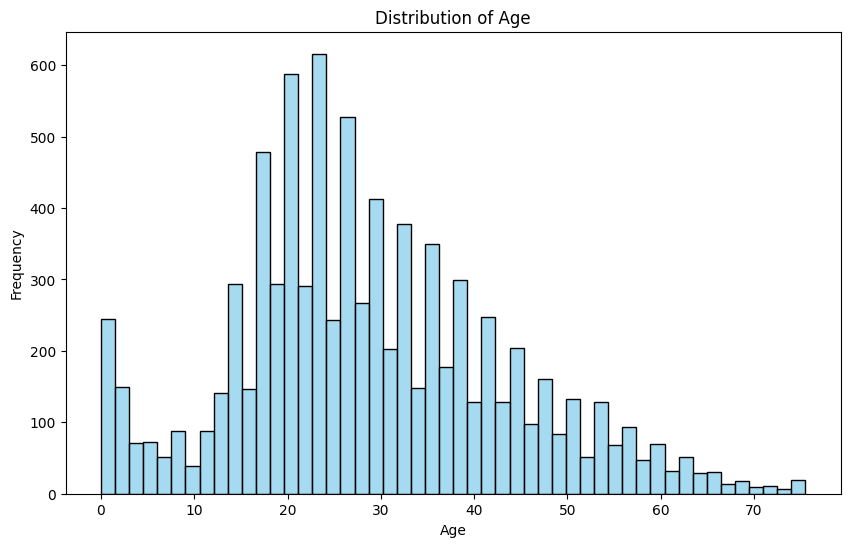

In [30]:
draw_histogram(data_train, 'Age', 'Distribution of Age')

In [31]:
data_train = normalize_numerical(data_train, 'Age', scaler_type='RobustScaler')

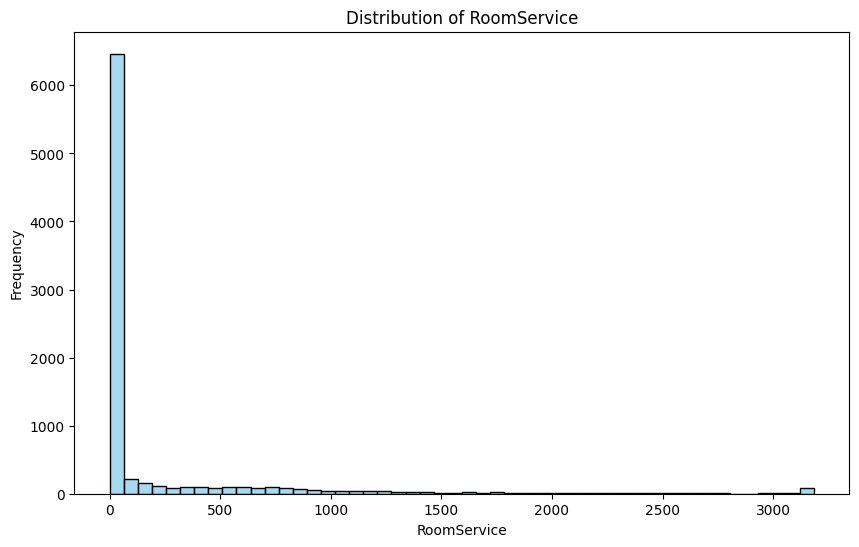

In [32]:
draw_histogram(data_train, 'RoomService', 'Distribution of RoomService')

In [33]:
data_train = normalize_numerical(data_train, 'RoomService', scaler_type='RobustScaler')

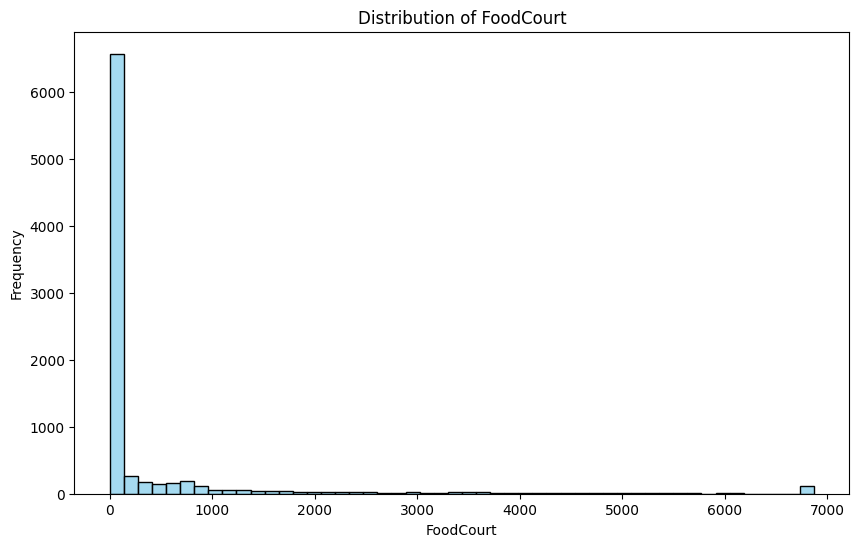

In [34]:
draw_histogram(data_train, 'FoodCourt', 'Distribution of FoodCourt')

In [35]:
data_train = normalize_numerical(data_train, 'FoodCourt', scaler_type='RobustScaler')

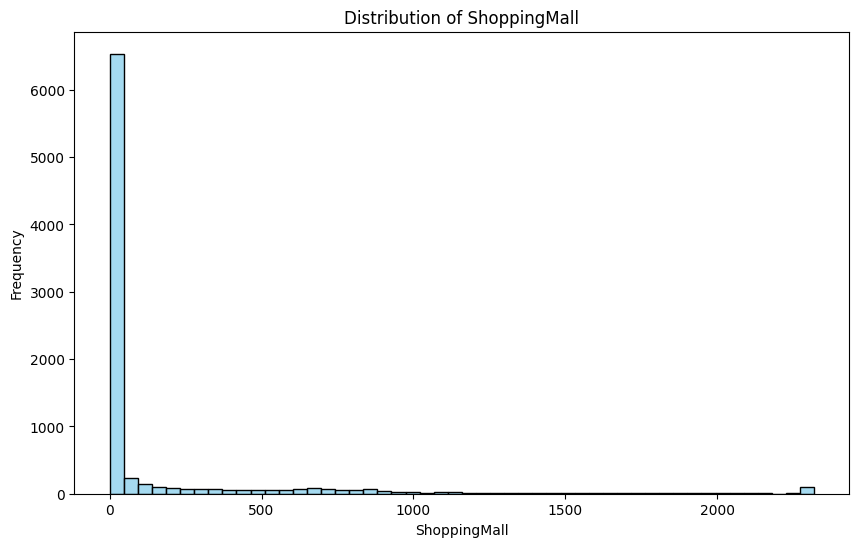

In [36]:
draw_histogram(data_train, 'ShoppingMall', 'Distribution of ShoppingMall')

In [37]:
data_train = normalize_numerical(data_train, 'ShoppingMall', scaler_type='RobustScaler')

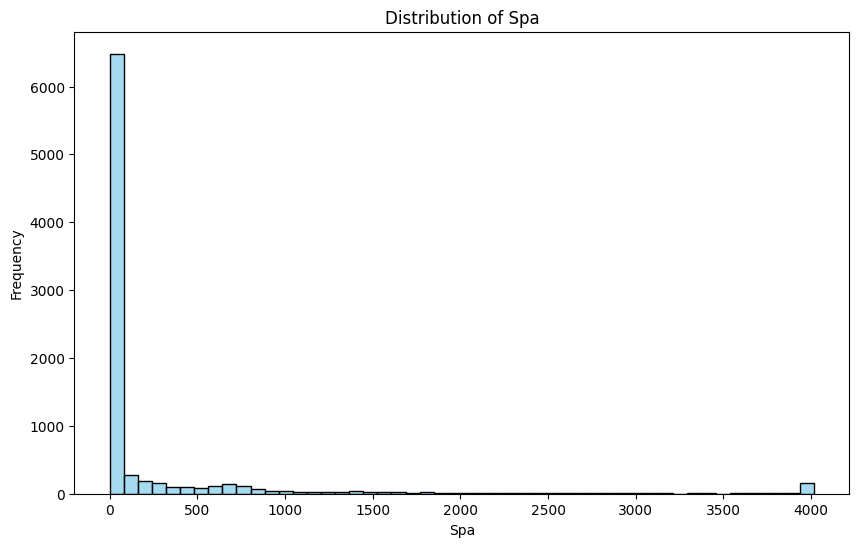

In [38]:
draw_histogram(data_train, 'Spa', 'Distribution of Spa')

In [39]:
data_train = normalize_numerical(data_train, 'Spa', scaler_type='RobustScaler')

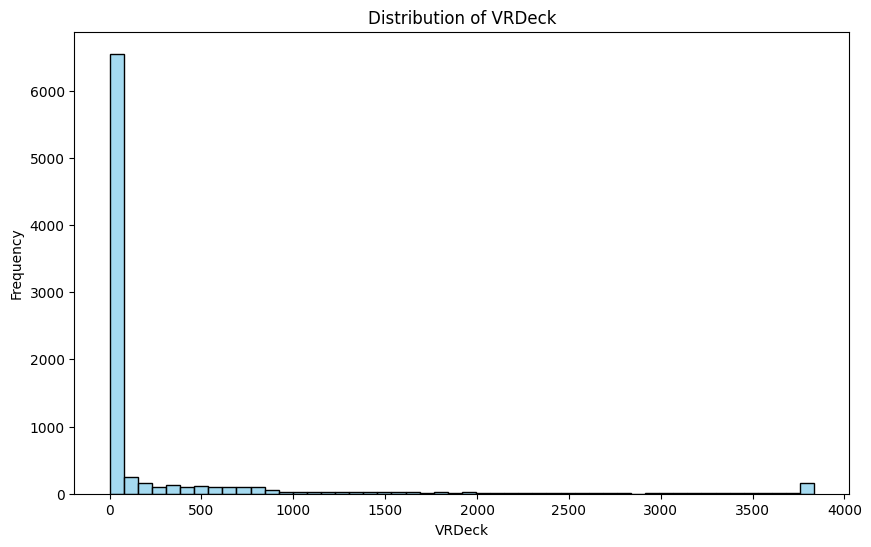

In [40]:
draw_histogram(data_train, 'VRDeck', 'Distribution of VRDeck')

In [41]:
data_train = normalize_numerical(data_train, 'VRDeck', scaler_type='RobustScaler')

All the numercal values have been normalized using RobustScaler due to it's flexibility when dealing with data that has outliers. Yes, a portion of outliers has already been resolved but only a very small part of it due to my personal belief that remaining outliers have some significance and will improve my models.

## kNN imputation
In order to resolve missing values issue, kNN imputation will be performed.

In [42]:
data_train_original = data_train.copy()

Creating a copy of the dataset for kNN evaluation.

In [43]:
continuous_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'room_number']
binary_columns = ['CryoSleep', 'VIP', 'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
                  'Destination_PSO J318.5-22', 'port', 'starboard', 'deck_A', 'deck_B', 'deck_C', 'deck_D', 'deck_E', 'deck_F', 'deck_G', 'deck_T']

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 11)
errors = []

for k in k_values:
    continuous_error_sum = 0
    binary_error_sum = 0
    
    for train_index, test_index in kf.split(data_train):
        train_data, test_data = data_train.iloc[train_index], data_train.iloc[test_index]
        
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(train_data)
        
        imputed_data = pd.DataFrame(imputer.transform(test_data), columns=test_data.columns, index=test_data.index)
        
        continuous_error, binary_error = calculate_imputation_error(test_data, imputed_data, continuous_columns, binary_columns)
        continuous_error_sum += continuous_error
        binary_error_sum += binary_error
    
    errors.append((k, continuous_error_sum / kf.get_n_splits(), binary_error_sum / kf.get_n_splits()))


In [45]:
errors = pd.DataFrame(errors, columns=['k', 'continuous_error', 'binary_error'])
optimal_k = errors.loc[errors['continuous_error'].idxmin(), 'k']

print(f"Optimal number of neighbors: {optimal_k}")

Optimal number of neighbors: 1


In [46]:
final_imputer = KNNImputer(n_neighbors=int(optimal_k))
data_train_imputed = final_imputer.fit_transform(data_train)
data_train_imputed_df = pd.DataFrame(data_train_imputed, columns=data_train.columns)

Data has been imputed. Now let's compare original vs imputed data distributions in each numerical column.

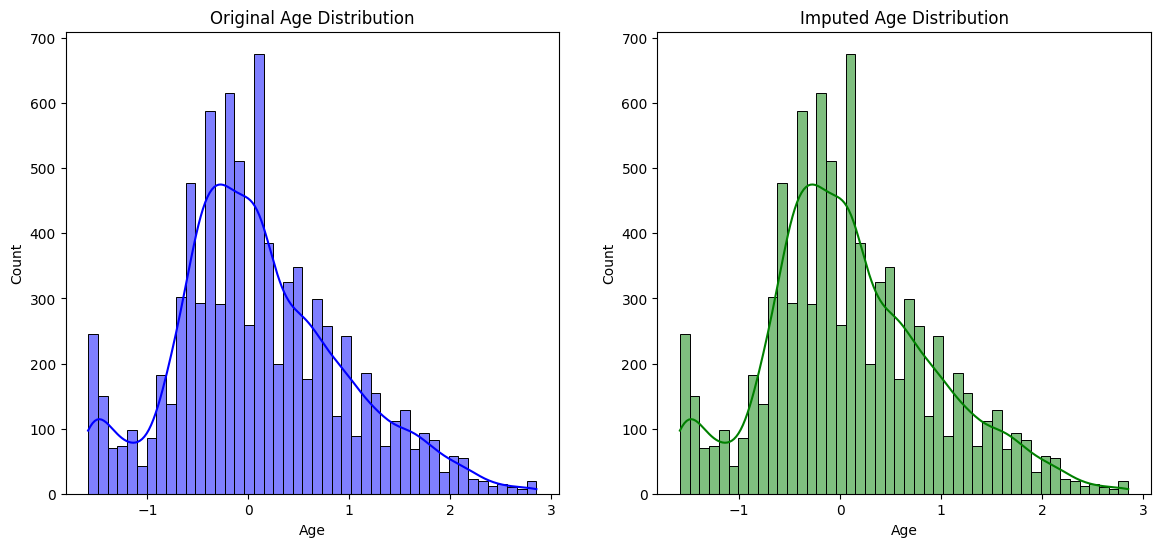

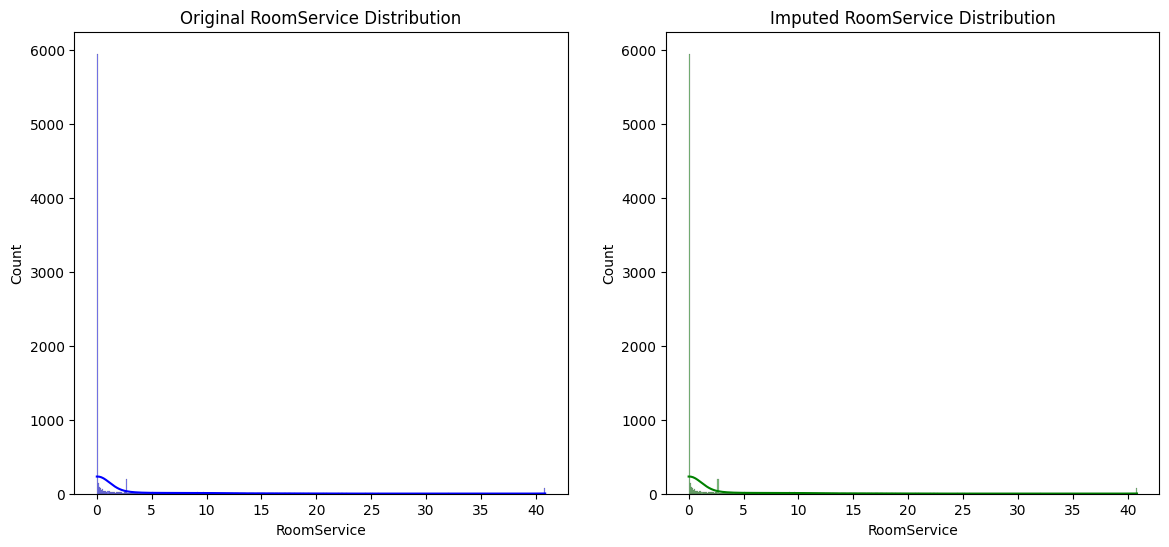

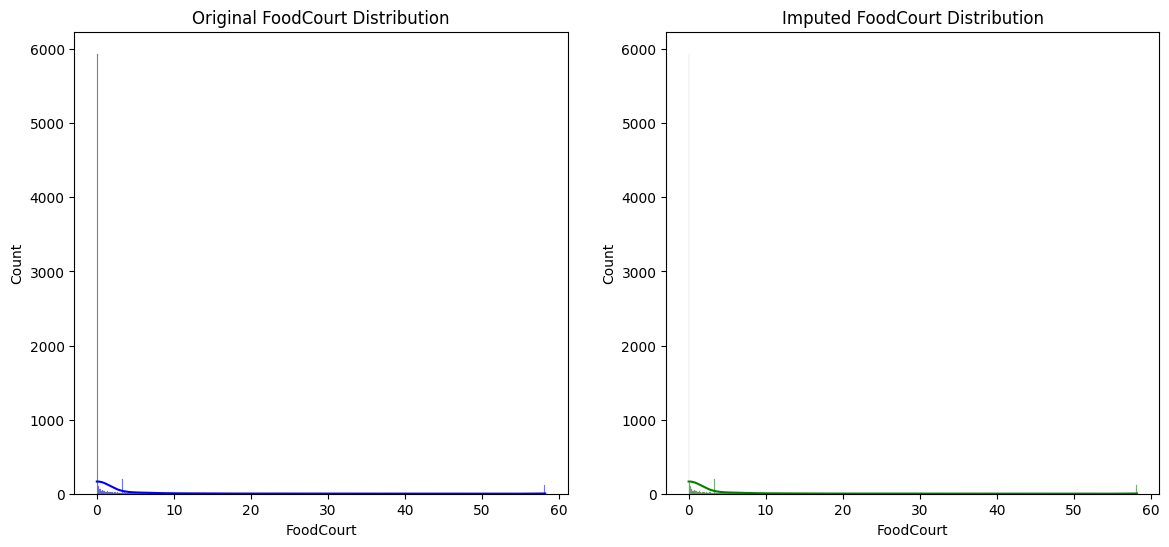

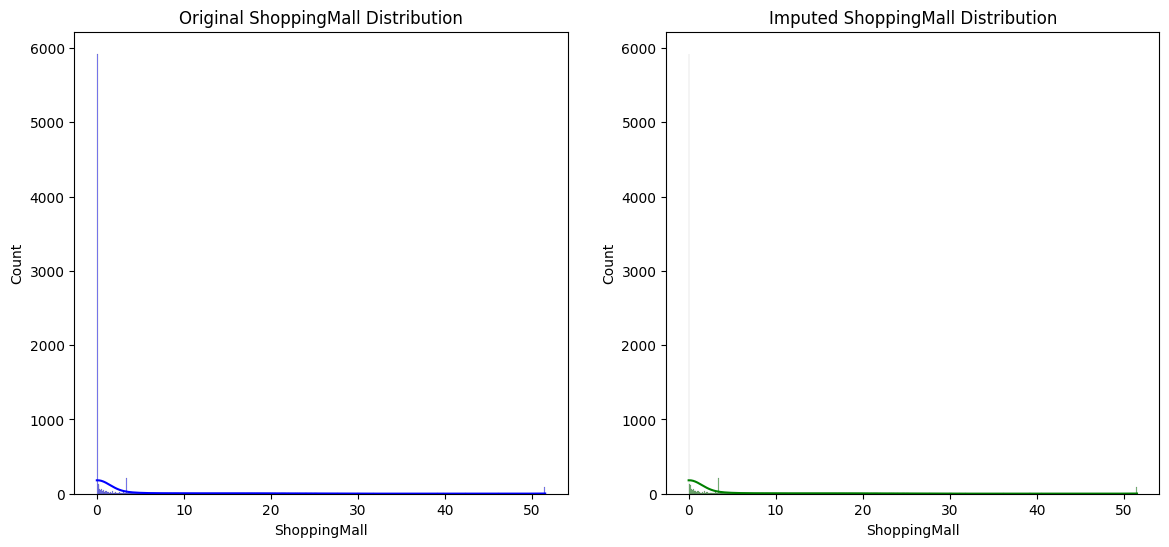

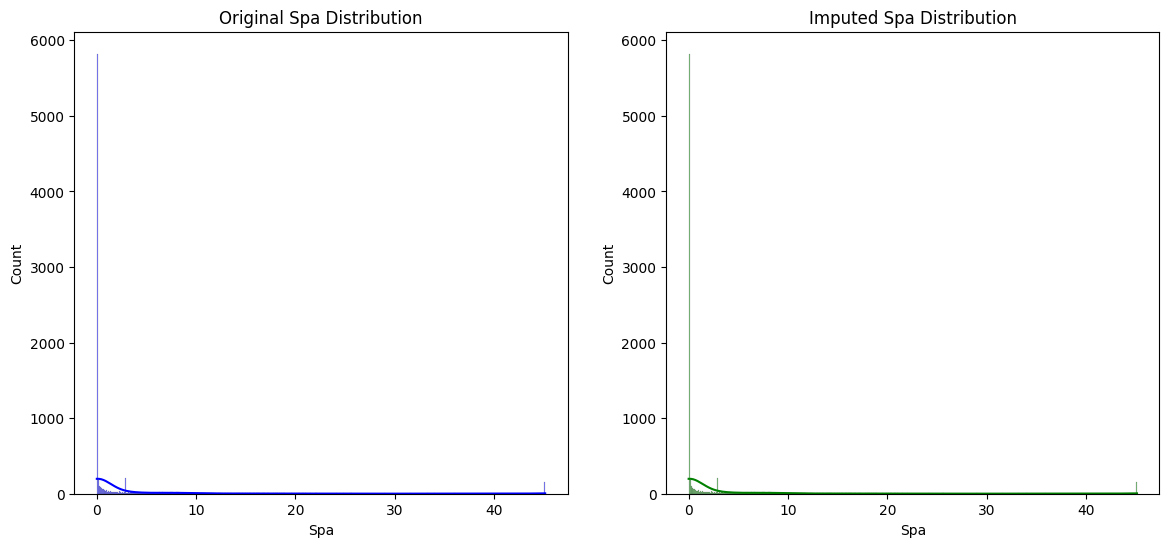

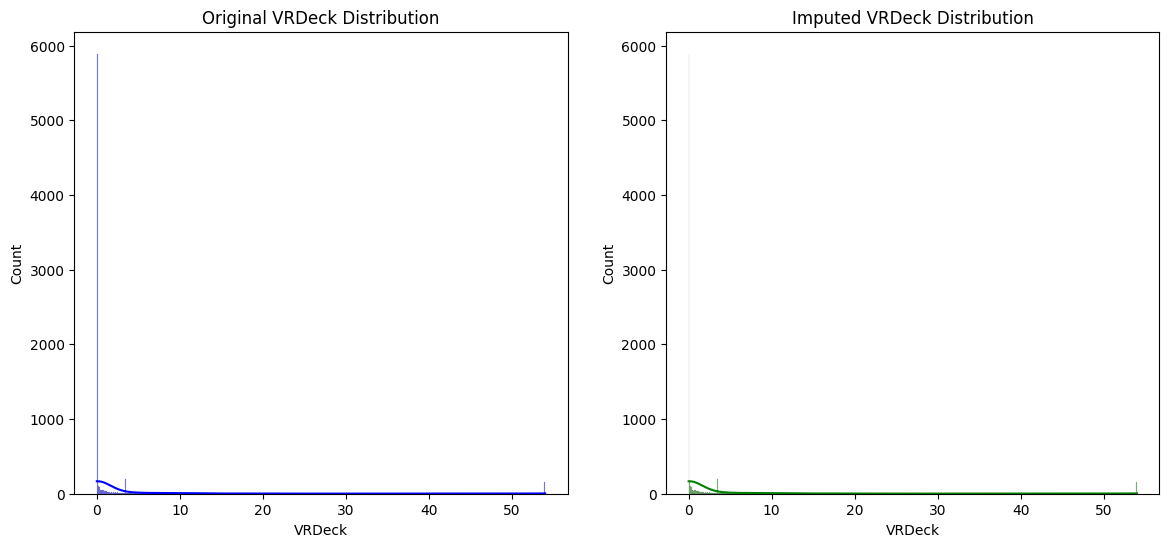

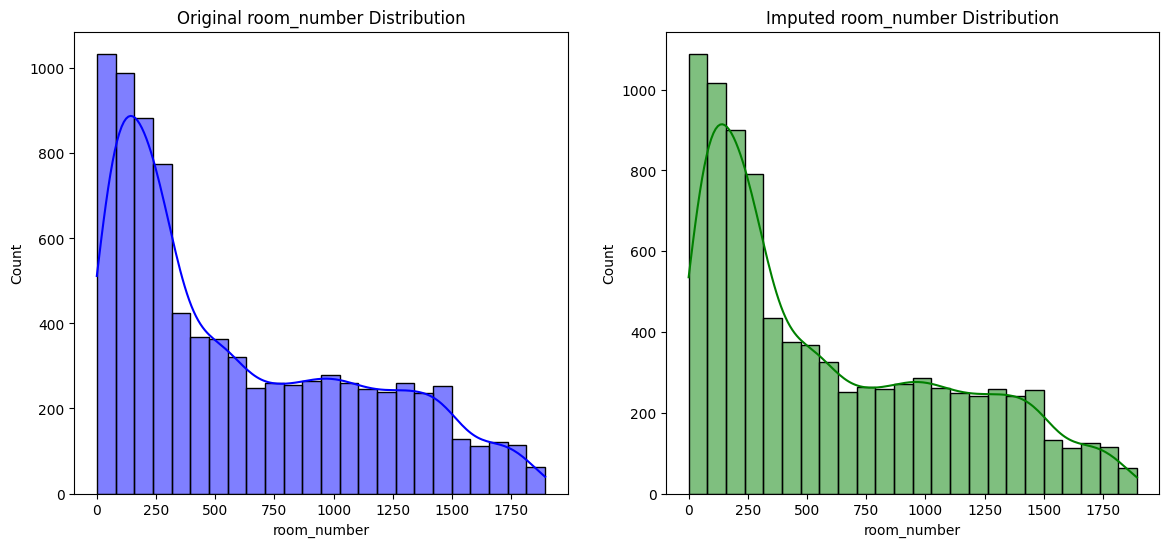

Original Data with Missing Values:
        Age  RoomService  FoodCourt  ShoppingMall        Spa    VRDeck  \
0  0.705882     0.000000   0.000000      0.000000   0.000000  0.000000   
1 -0.176471     1.397436   0.076271      0.555556   6.168539  0.619718   
2  1.823529     0.551282  30.305085      0.000000  45.143258  0.690141   
3  0.352941     0.000000  10.872881      8.244444  37.404494  2.718310   
4 -0.647059     3.884615   0.593220      3.355556   6.348315  0.028169   
5  1.000000     0.000000   4.093220      0.000000   3.269663  0.000000   
6 -0.058824     0.538462  13.042373      0.066667   0.000000  0.000000   
7  0.058824     0.000000   0.000000      0.000000   0.000000  3.441525   
8  0.470588     0.000000   6.652542      0.377778   2.426966  0.000000   
9 -0.764706     0.000000   0.000000      0.000000   0.000000  0.000000   

   room_number  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          1.0  
5          0.0  
6          2.0  
7          0.0

In [47]:
for column in continuous_columns:
    visualize_imputation(data_train_original, data_train_imputed_df, column)

print("Original Data with Missing Values:")
print(data_train_original[continuous_columns].head(10))

print("\nImputed Data:")
print(data_train_imputed_df[continuous_columns].head(10))

From the eye test, visualizations show relatively similar distrubutions suggesting successful imputation. This is further confirmed by the statistical summaries.

To confirm imputation even more confidently, inferential statistics will be used.
For numerical features Kolmogorov-Smirnov (KS) test will be used while for categorical features proportion Z-test will be used.
 
**H0**: There is no significant statistical difference between the original and imputed data.
**H1**: There is a significant statistical difference between the original and imputed data.

In [48]:
for column in continuous_columns:
    stat, p_value = ks_test(data_train_original, data_train_imputed_df, column)
    print(f"KS test for {column}:")
    print(f" - Statistic: {stat}")
    print(f" - P-value: {p_value}")
    if p_value < 0.05:
        print(f" - Significant difference (reject H0)")
    else:
        print(f" - No significant difference (fail to reject H0)")
    print("-" * 50)

KS test for Age:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for RoomService:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for FoodCourt:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for ShoppingMall:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for Spa:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for VRDeck:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
KS test for room_number:
 - Statistic: 0.0
 - P-value: 1.0
 - No sig

In [49]:
for column in binary_columns:
    stat, p_value = proportion_test(data_train_original, data_train_imputed_df, column)
    print(f"Proportion z-test for {column}:")
    print(f" - Statistic: {stat}")
    print(f" - P-value: {p_value}")
    if p_value < 0.05:
        print(f" - Significant difference (reject H0)")
    else:
        print(f" - No significant difference (fail to reject H0)")
    print("-" * 50)

Proportion z-test for CryoSleep:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
Proportion z-test for VIP:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
Proportion z-test for Transported:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
Proportion z-test for HomePlanet_Earth:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
Proportion z-test for HomePlanet_Europa:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------------------------
Proportion z-test for HomePlanet_Mars:
 - Statistic: 0.0
 - P-value: 1.0
 - No significant difference (fail to reject H0)
--------------------------------

Statistical tests confirmed successful imputation as H0 was not rejected in all tests. Now the last and final step in regards to missing features, let's just confirm that this data has NO missing values anywhere.

In [50]:
num_rows_with_missing_values = data_train_imputed_df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {num_rows_with_missing_values}")
print('Total:', data_train_imputed_df.shape[0])

Number of rows with at least one missing value: 0
Total: 8693


There's no missing data left. Let's move to modelling part.

# Machine Learning

## Data Preparation

Since the data was originally split, no more splitting will be done. Only the target feature will be separated from the rest of the data.

In [51]:
X = data_train_imputed_df.drop(columns=['Transported'])
y = data_train_imputed_df['Transported']
print(X.shape)
print(y.shape)

(8693, 25)
(8693,)


## Modelling

### LightGBM

LigthGBM is a relatively advanced and fast gradient boosting framework that allows to investigate feature importance. That's why it was chosen to be the first model.
In order to find the best hyperparameters for the model, Optuna library was used with accuracy being the metric to optimize for.

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: suggest_hyperparameters(trial, X, y, 'lightgbm'), n_trials=100)

print("Best parameters found: ", study.best_params)
print("Best accuracy score: ", study.best_value)

In [52]:
params_lgbm = {
    'num_leaves': 24,
    'max_depth': 18,
    'learning_rate': 0.010439641686481772,
    'n_estimators': 239,
    'min_child_weight': 4,
    'subsample': 0.8048855063047688,
    'colsample_bytree': 0.981593216066641,
    'reg_alpha': 9.160574544208869e-05,
    'reg_lambda': 2.991591218846236e-05,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
    'silent': True
}

lgb_model_final = lgb.LGBMClassifier(**params_lgbm)
results_lgb = cross_validate(lgb_model_final, X, y)


Model: LGBMClassifier
Cross-validated Accuracy: 0.8042
Cross-validated Logloss: 0.4171


After hyperparameter tuning model's cross-validation results showed aboe 80% accuracy with relatively small logloss! Let's see the feature importance of the model.

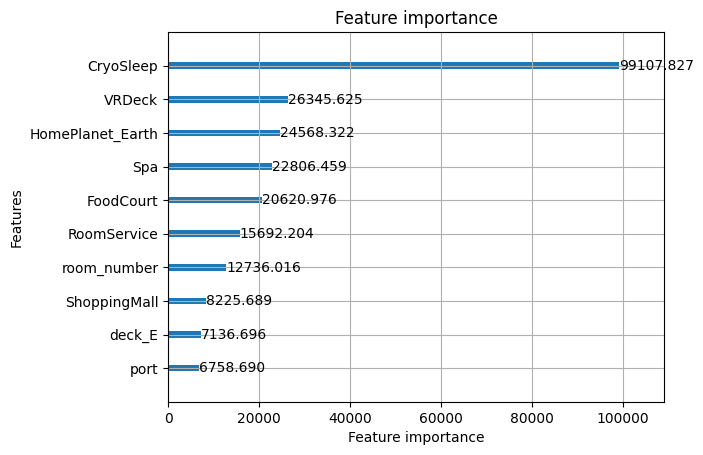

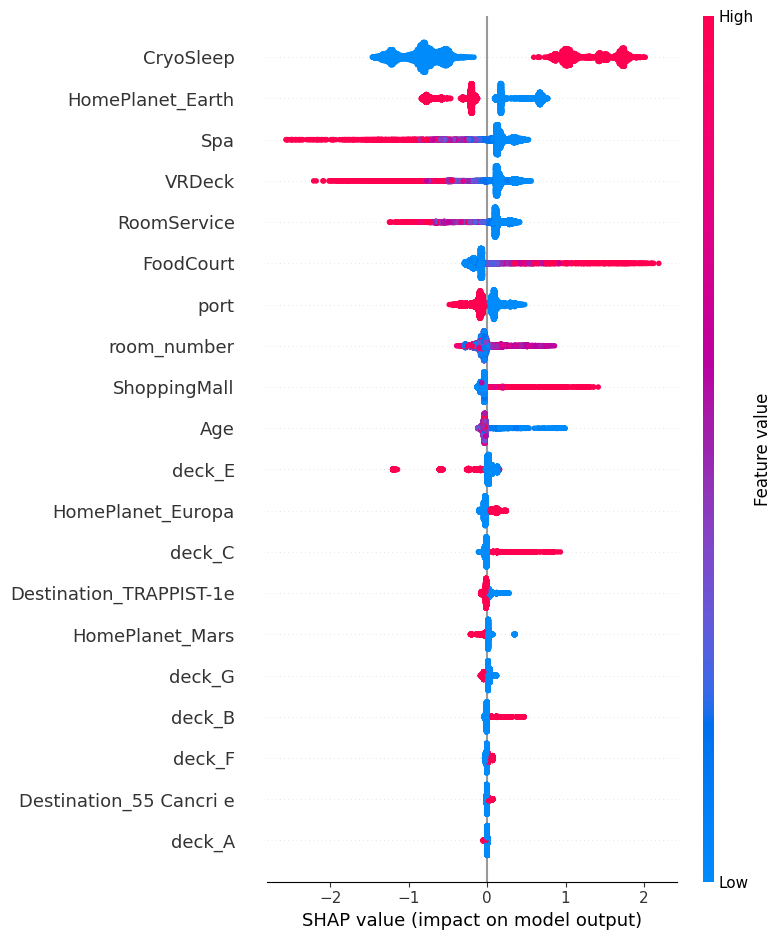

In [53]:
lgb_model_final.fit(X, y)
lgb.plot_importance(lgb_model_final, max_num_features=10, importance_type='gain')
plt.show()

explainer = shap.TreeExplainer(lgb_model_final)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

**1st chart:** Feature importance was calculated via count of occurences of a feature in the model. CyroSleep, home planet Earth and numerical spending features appeared the most in this model.  
**2nd chart:** SHAP values show the impact of each feature on the model output. It's more advanced that feature importance above since it measures the impact using SHAP metric which helps estimate how positive and negative values of a feature affect the model output. The most important features remain the same with slightly different order.

Overfitting is a serious issue in Data Science. In order to reduce the risk as much as possible, will try out LightGBM once again but only using the most important features.

In [54]:
selected_features = [
    'CryoSleep', 'HomePlanet_Earth', 'Spa', 'VRDeck', 
    'RoomService', 'FoodCourt', 'port', 'room_number', 'ShoppingMall'
]

X_reduced = X[selected_features]

Once again, we will use Optuna to find the best hyperparameters for the LightGBM model.

In [ ]:
study_reduced = optuna.create_study(direction='maximize')
study_reduced.optimize(lambda trial: suggest_hyperparameters(trial, X_reduced, y, 'lightgbm'), n_trials=100)

print("Best parameters found: ", study_reduced.best_params)
print("Best accuracy score: ", study_reduced.best_value)

In [55]:
params_lgbm_reduced = {
    'num_leaves': 20,
    'max_depth': 17,
    'learning_rate': 0.012214563235941259,
    'n_estimators': 188,
    'min_child_weight': 2,
    'subsample': 0.7037261353230697,
    'colsample_bytree': 0.9666389156304147,
    'reg_alpha': 0.0038822309256305912,
    'reg_lambda': 2.51877091192019e-05,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
    'silent': True
}

lgb_model_reduced = lgb.LGBMClassifier(**params_lgbm_reduced)
results_lgb_reduced = cross_validate(lgb_model_reduced, X_reduced, y)
lgb_model_reduced.fit(X_reduced, y)

Model: LGBMClassifier
Cross-validated Accuracy: 0.7940
Cross-validated Logloss: 0.4449


LGBMClassifier(colsample_bytree=0.9666389156304147,
               learning_rate=0.012214563235941259, max_depth=17,
               min_child_weight=2, n_estimators=188, n_jobs=-1, num_leaves=20,
               random_state=42, reg_alpha=0.0038822309256305912,
               reg_lambda=2.51877091192019e-05, silent=True,
               subsample=0.7037261353230697, verbose=-1)

Model appears to be slightly less accurate but considering it used only a portion of the features that were used in the full model, it should still be considered a good model.

### XGBoost

Identical approach as with LightGBM. Using Optuna to find the best hyperparameters.

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: suggest_hyperparameters(trial, X, y, 'xgboost'), n_trials=100)

print("Best parameters found: ", study.best_params)
print("Best accuracy score: ", study.best_value)

In [56]:
params_xgb = {
 'max_depth': 4,
 'learning_rate': 0.030057817508066263,
 'gamma': 0.9437417553078634,
 'reg_lambda': 4.328208287740791,
 'scale_pos_weight': 1,
 'min_child_weight': 5,
 'n_estimators': 236,
}

xgb_model_final = xgb.XGBClassifier(**params_xgb)
results_xgb = cross_validate(xgb_model_final, X, y)
xgb_model_final.fit(X, y)

Model: XGBClassifier
Cross-validated Accuracy: 0.8008
Cross-validated Logloss: 0.4096


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9437417553078634, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.030057817508066263,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=236, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Model is slightly worse than LightGBM but still provides acceptable results (accuracy > 79%!).  
Now let's create another XGB model but using only the top features as identified by LightGBM.

In [ ]:
study_reduced = optuna.create_study(direction='maximize')
study_reduced.optimize(lambda trial: suggest_hyperparameters(trial, X_reduced, y, 'xgboost'), n_trials=100)

print("Best parameters found: ", study_reduced.best_params)
print("Best accuracy score: ", study_reduced.best_value)

In [57]:
params_xgb_reduced = {
 'max_depth': 3,
 'learning_rate': 0.026395660642307136,
 'gamma': 0.13645797332623888,
 'reg_lambda': 0.3692679943321832,
 'scale_pos_weight': 1,
 'min_child_weight': 2,
 'n_estimators': 189,
}

xgb_model_reduced = xgb.XGBClassifier(**params_xgb_reduced)
results_xgb_reduced = cross_validate(xgb_model_reduced, X_reduced, y)
xgb_model_reduced.fit(X_reduced, y)

Model: XGBClassifier
Cross-validated Accuracy: 0.7966
Cross-validated Logloss: 0.4431


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.13645797332623888, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.026395660642307136,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=189, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Similar results as with LightGBM, reduced model is slightly worse but still has good enough accuracy.

### CatBoost

Once again, same approach is followed for CatBoost. Optuna finds best hyperparameters, model is trained with full data and alternative (reduced) model is trained only with top features.

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: suggest_hyperparameters(trial, X, y, 'catboost'), n_trials=100)

print("Best parameters found: ", study.best_params)
print("Best accuracy score: ", study.best_value)

In [58]:
params_catboost = {
    'depth': 6,
    'learning_rate': 0.00929840187875209,
    'iterations': 259,
    'l2_leaf_reg': 1.399059609689069e-05,
    'subsample': 0.7809948375102388,
    'rsm': 0.8164321062357653,
    'random_seed': 42,
    'silent': True
}

catboost_model_final = cb.CatBoostClassifier(**params_catboost)
results_catboost = cross_validate(catboost_model_final, X, y)
catboost_model_final.fit(X, y)

Model: CatBoostClassifier
Cross-validated Accuracy: 0.8013
Cross-validated Logloss: 0.4291


In [ ]:
study_reduced = optuna.create_study(direction='maximize')
study_reduced.optimize(lambda trial: suggest_hyperparameters(trial, X_reduced, y, 'catboost'), n_trials=100)

print("Best parameters found: ", study_reduced.best_params)
print("Best accuracy score: ", study_reduced.best_value)

In [59]:
params_catboost_reduced = {
    'depth': 6,
    'learning_rate': 0.014314803930765377,
    'iterations': 286,
    'l2_leaf_reg': 0.0005458765549284564,
    'subsample': 0.7138458213265043,
    'rsm': 0.9140124591278106,
    'random_seed': 42,
    'silent': True
}

catboost_model_reduced = cb.CatBoostClassifier(**params_catboost_reduced)
results_catboost_reduced = cross_validate(catboost_model_reduced, X_reduced, y)
catboost_model_reduced.fit(X_reduced, y)

Model: CatBoostClassifier
Cross-validated Accuracy: 0.7957
Cross-validated Logloss: 0.4309


It appears that CatBoost follows the same pattern as previous models:
- Accuracy > 79%
- Reduced model slightly worse but still accuracy > 79%

### Voting Classifier

Voting classifier is an ensemble method that combines predictions from multiple models. It uses the majority voting to make the final prediction. In simple terms, it combines all the best parts of multiple models.

In [60]:
voting_classifier_full = VotingClassifier(
    estimators=[
        ('lightgbm', lgb_model_final),
        ('xgboost', xgb_model_final),
        ('catboost', catboost_model_final)
    ],
    voting='soft'
)


voting_classifier_reduced = VotingClassifier(
    estimators=[
        ('lightgbm_reduced', lgb_model_reduced),
        ('xgboost_reduced', xgb_model_reduced),
        ('catboost_reduced', catboost_model_reduced)
    ],
    voting='soft'
)

results_full = cross_validate(voting_classifier_full, X, y, cv=5)
results_reduced = cross_validate(voting_classifier_reduced, X, y, cv=5)
voting_classifier_full.fit(X, y)
voting_classifier_reduced.fit(X_reduced, y)

Model: VotingClassifier
Cross-validated Accuracy: 0.8036
Cross-validated Logloss: 0.4141
Model: VotingClassifier
Cross-validated Accuracy: 0.8031
Cross-validated Logloss: 0.4182


VotingClassifier(estimators=[('lightgbm_reduced',
                              LGBMClassifier(colsample_bytree=0.9666389156304147,
                                             learning_rate=0.012214563235941259,
                                             max_depth=17, min_child_weight=2,
                                             n_estimators=188, n_jobs=-1,
                                             num_leaves=20, random_state=42,
                                             reg_alpha=0.0038822309256305912,
                                             reg_lambda=2.51877091192019e-05,
                                             silent=True,
                                             subsample=0.7037261353230697,
                                             verbose=-1)),
                             ('xgboos...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=189, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('catboost_reduced',
                              <catboost.core.CatBoostClassifier object at 0x0000025276B74250>)],
                 voting='soft')

Voting classifier seems to follow the same pattern as the individual models. It has satisfactory accuracy but reduced version is slightly worse. However, there's a significant improvement since the difference between full and reduced model is significantly smaller than in the individual models.

## Model evaluation

It's difficult to compare models when they are separated by multiple cells of code. Let's create a table to compare the models side by side.

In [61]:
results_list = [results_xgb, results_xgb_reduced, results_lgb, results_lgb_reduced,
                results_catboost, results_catboost_reduced, results_full, results_reduced]

In [62]:
accuracy_table = create_comparison_table(results_list, 'accuracy')
logloss_table = create_comparison_table(results_list, 'logloss')

In [63]:
accuracy_table

,Model,Full,Reduced,Difference
0,XGBClassifier,0.800759,0.796618,0.004141
1,LGBMClassifier,0.804210,0.793972,0.010238
2,CatBoostClassifier,0.801334,0.795698,0.005637
3,VotingClassifier,0.803635,0.803060,0.000575


- LightGBM Full model has the highest accuracy.
- LightGBM has the largest accuracy difference of full and reduced models.
- XGB and CatBoost models have similar accuracy scores.
- Voting Classifier model appears to be the best and most balanced model due to it having second highest (and close to the highest) accuracy score and smallest accuracy difference between full and reduced models.

In [64]:
logloss_table

,Model,Full,Reduced,Difference
0,XGBClassifier,0.409568,0.443102,0.033534
1,LGBMClassifier,0.417082,0.444940,0.027858
2,CatBoostClassifier,0.429080,0.430871,0.001791
3,VotingClassifier,0.414113,0.418153,0.004040


- XGB Full model has the highest confidence in it's predictions, with the lowest log loss score.
- XGB shows the largest difference in logloss between the full and reduced models.
- CatBoost has the highest logloss showing the lowest confidence in it's predictions. However, it has the smallest difference in full vs reduced model indicating it's robustness to feature selection.
- Once again Voting Classifier appears to be the mid option with relatively small difference in full vs reduced model logloss while the logloss itself being the second lowest in full model and the lowest in reduced model.

# Model testing

High cross validation accuracy scores indicate that models are already performing well. However, this needs to be confirmed by the test set.  
In order to simplify the process, a custom `preprocess_and_impute_data_test()` function is created to apply the same preprocessing steps to the test data.

In [65]:
data_test = pd.read_csv('data/test.csv', dtype={'PassengerId': str})
data_test_preprocessed = preprocess_and_impute_data_test(data_test)
data_test_preprocessed.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,starboard,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,PassengerId
0,1.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0013_01
1,0.0,-0.470588,0.0,0.000000,0.062937,0.00000,34.012048,0.000000,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0018_01
2,1.0,0.235294,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0019_01
3,0.0,0.647059,0.0,0.000000,46.517483,0.00000,2.180723,11.037736,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0021_01
4,0.0,-0.411765,0.0,0.126582,0.000000,12.45098,0.000000,0.000000,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0023_01


In [66]:
data_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   float64
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   float64
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   HomePlanet_Earth           4277 non-null   float64
 9   HomePlanet_Europa          4277 non-null   float64
 10  HomePlanet_Mars            4277 non-null   float64
 11  Destination_55 Cancri e    4277 non-null   float64
 12  Destination_PSO J318.5-22  4277 non-null   float64
 13  Destination_TRAPPIST-1e    4277 non-null   float

In [67]:
X_test = data_test_preprocessed.drop(columns=['PassengerId'])
passenger_ids = data_test_preprocessed['PassengerId']

And finally, all the models will make predictions on the test data and the results will be saved in separate CSV files only containing the PassengerId and the prediction.

In [68]:
models = {
    'lgb_model_final': lgb_model_final,
    'lgb_model_reduced': lgb_model_reduced,
    'xgb_model_final': xgb_model_final,
    'xgb_model_reduced': xgb_model_reduced,
    'catboost_model_final': catboost_model_final,
    'catboost_model_reduced': catboost_model_reduced,
    'voting_classifier_full': voting_classifier_full,
    'voting_classifier_reduced': voting_classifier_reduced
}

selected_features = [
    'CryoSleep', 'HomePlanet_Earth', 'Spa', 'VRDeck', 
    'RoomService', 'FoodCourt', 'port', 'room_number', 'ShoppingMall'
]

for model_name, model in models.items():
    print(f"Making predictions using {model_name}...")
    
    if "_reduced" in model_name:
        X_to_use = X_test[selected_features]
    else:
        X_to_use = X_test
    
    predictions = model.predict(X_to_use)
    output_df = pd.DataFrame({
        'PassengerId': passenger_ids,
        'Transported': predictions
    })
    
    output_df['Transported'] = output_df['Transported'].astype(int).replace({0: False, 1: True})
    
    output_csv = f"data/{model_name}_predictions.csv"
    output_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")

Making predictions using lgb_model_final...
Predictions saved to data/lgb_model_final_predictions.csv
Making predictions using lgb_model_reduced...
Predictions saved to data/lgb_model_reduced_predictions.csv
Making predictions using xgb_model_final...
Predictions saved to data/xgb_model_final_predictions.csv
Making predictions using xgb_model_reduced...
Predictions saved to data/xgb_model_reduced_predictions.csv
Making predictions using catboost_model_final...
Predictions saved to data/catboost_model_final_predictions.csv
Making predictions using catboost_model_reduced...
Predictions saved to data/catboost_model_reduced_predictions.csv
Making predictions using voting_classifier_full...
Predictions saved to data/voting_classifier_full_predictions.csv
Making predictions using voting_classifier_reduced...
Predictions saved to data/voting_classifier_reduced_predictions.csv


# Kaggle

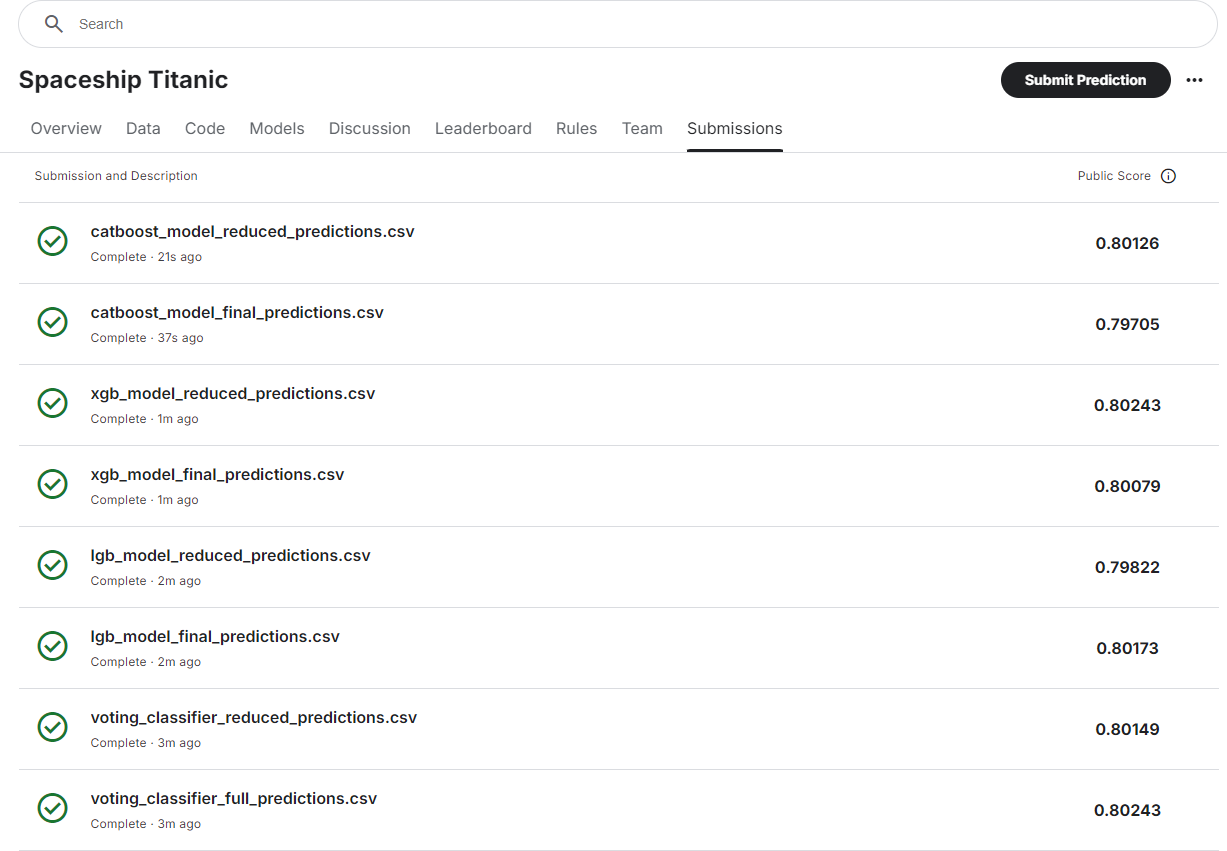

In [69]:
image_path = 'data/kaggle submissions.PNG'
display(Image(filename=image_path))

- All models have reached the minimum of 79% accuracy.
- Two best perfodming models were the Voting Classifier with all features and XGB Classifier with reduced features.
- Accuracy scores are somewhat similar to cross-validation results indicating appropriate cross validation method.

# Conclusion
After intensive data cleaning and preparation all the models (after hypertuning) have reached the minimum of 79% accuracy. The best performing models were the Voting Classifier with all features and XGB Classifier with reduced features. However, since XGB with reduced features was performing so well, it should be chosen if another "Spaceship Titanic" happens again since there's a small possibility that Voting Classifier might be overfitting.

# Potential improvements
- More feature engineering can be done to improve the model.
- With more computing power, GridSearchCV could be used to find the best hyperparameters since this method was producing even better results in the developmental phase for XGBoost. This approach was discontinued and later removed due to immense computational power it would need for LightGBM and CatBoost in order to maintain consistency and simplicity accross all the models.
- Since only 3 models were used here, there's a potential that there are other models that could perform better.
- It's still unknown whether it's worth to split training data once again. It would be interesting to see if this approach yields better results but due to time constraints, this alternative approach was not used.
- Could've used more advanced visualizations or improve existing ones like adding a legend with target feature (1 or 0) on barplots and historgrams.